In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2

In [2]:
import os

In [3]:
import sys
sys.path.append("../")

In [5]:
!ls ../data

download_images.py  raw		       sample_submission.csv
mask_functions.py   sample images      train-rle-1.csv
processed_256	    sample images.zip  train-rle.csv


# Read raw csv

In [6]:
df = pd.read_csv("../data/train-rle.csv", dtype="str", sep=", ")

/home/dzvinka/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [7]:
df.columns 

Index(['ImageId', 'EncodedPixels'], dtype='object')

In [8]:
df = df.groupby("ImageId")["EncodedPixels"].apply(list).reset_index()

In [9]:
df.iloc[0]["EncodedPixels"][0]

'-1'

In [10]:
len(df)

10675

# Processed Dataset Iteration

In [11]:
def iter_dataset(data_root="../data/processed_256/processed_256/"):
    for fn in os.listdir(os.path.join(data_root, "mask")):
        img = cv2.imread(os.path.join(data_root, "img", fn), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(data_root, "mask", fn), cv2.IMREAD_GRAYSCALE)
        yield img, mask

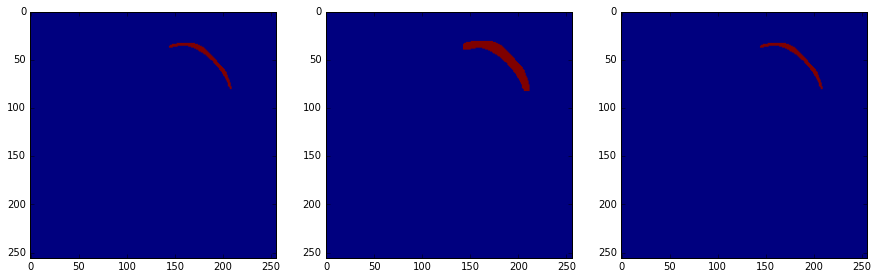

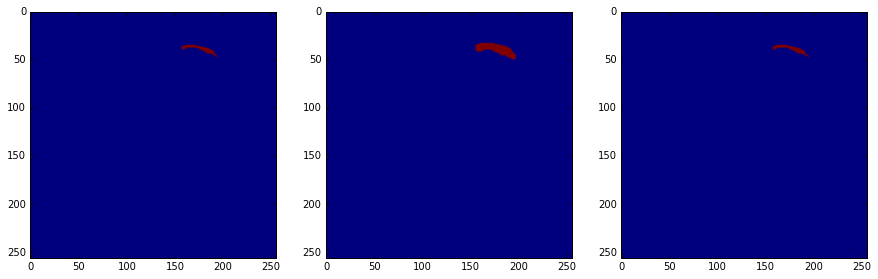

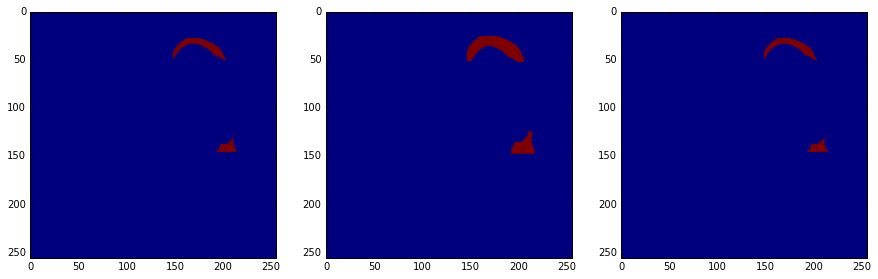

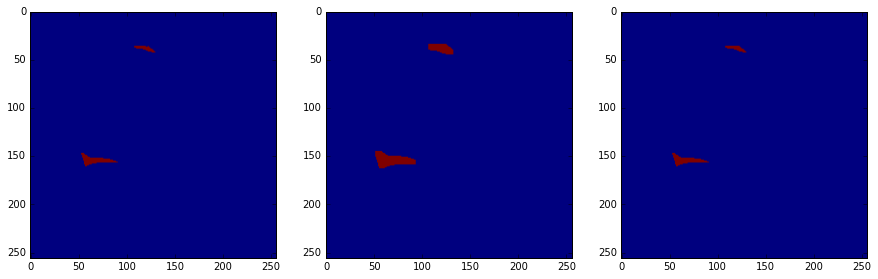

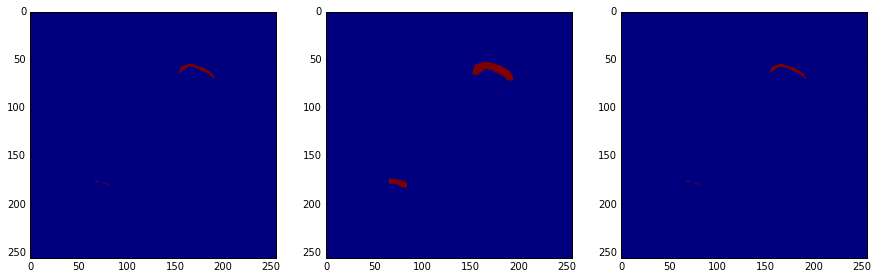

In [29]:
kernel = np.ones((3, 3), np.uint8)
for i, (img, mask) in enumerate(iter_dataset()):
    if i > 10:
        break
    if mask.any():
        mask = (mask > 0).astype(np.uint8)
        d_mask = cv2.dilate(mask, kernel, iterations=2)
    
        d_mask = (d_mask > 0).astype(np.uint8)
        e_mask = cv2.erode(d_mask, np.ones((3, 3), np.uint8), iterations=2)

        plt.figure(1, figsize=(15,5))
        plt.subplot(131)
        plt.imshow(mask)
        plt.subplot(132)
        plt.imshow(d_mask)
        plt.subplot(133)
        plt.imshow(e_mask)
        
        plt.show()

# Add paralelisation

In [12]:
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

In [13]:
def apply_all_data(f, *args, **kwargs):
    return Parallel(n_jobs=8, backend='threading')(delayed(
        f)(img_mask, *args, **kwargs) for img_mask in tqdm(iter_dataset(), total=10675))

# Find out area distribution

In [14]:
def find_area(img_mask):
    return (img_mask[1] > 0).sum()

sums = apply_all_data(find_area)

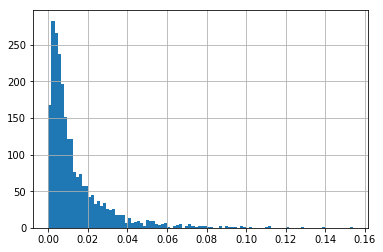

In [15]:
series = pd.Series(sums)/(1024*1024)
series = series[series > 0.0]
series.hist(bins=100)

In [25]:
hist[:2]

array([10521.,   129.])

In [28]:
bin_edges[:5]

array([     0.  ,  40355.25,  80710.5 , 121065.75, 161421.  ])

In [24]:
sorted(sums)[0]

0

[1.0521e+04 1.2900e+02 2.1000e+01 4.0000e+00]


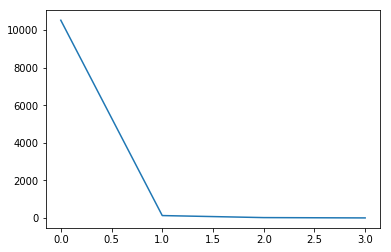

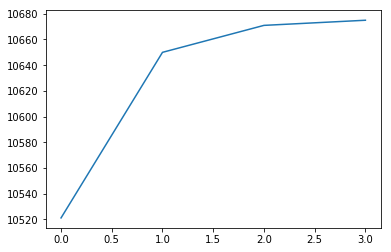

([<matplotlib.lines.Line2D at 0x7fe014896860>], None)

In [21]:
hist, bin_edges = np.histogram(sums, bins=4)
hist = hist.astype(np.float) # / (1024*1024)
print(hist)
plt.plot(hist), plt.show()
plt.plot(np.cumsum(hist)), plt.show()

In [22]:
bin_edges[:5]

array([     0.  ,  40355.25,  80710.5 , 121065.75, 161421.  ])

In [39]:
data = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 3, 4, 4, 4, 4, 4]
print(np.unique(data))
np.histogram(data, bins=2)

[1 2 3 4]


(array([11,  7]), array([1. , 2.5, 4. ]))

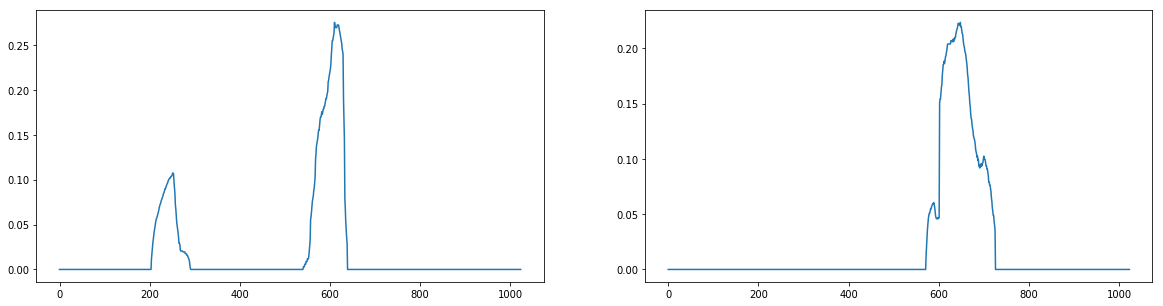

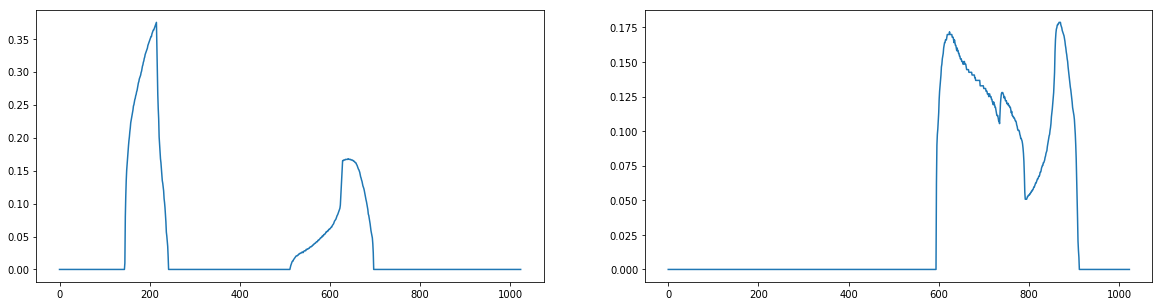

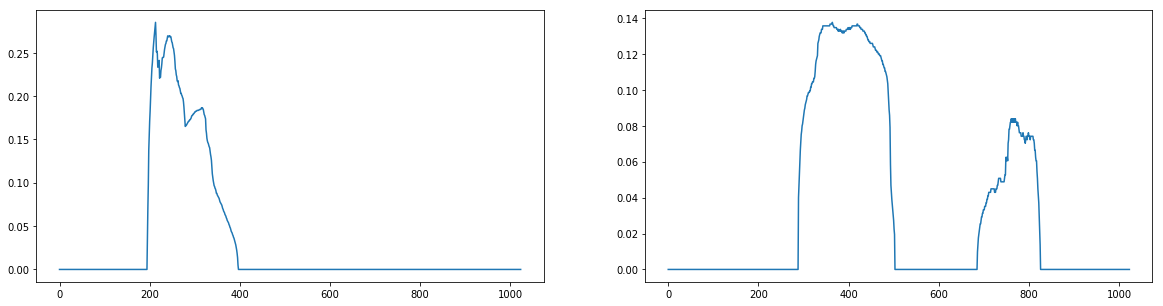

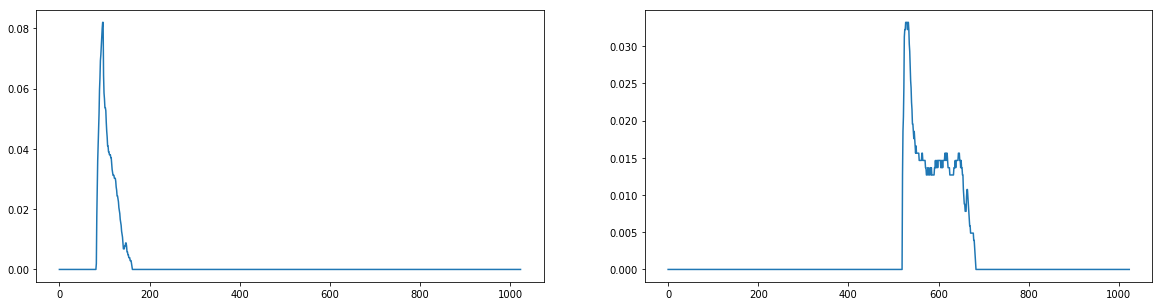

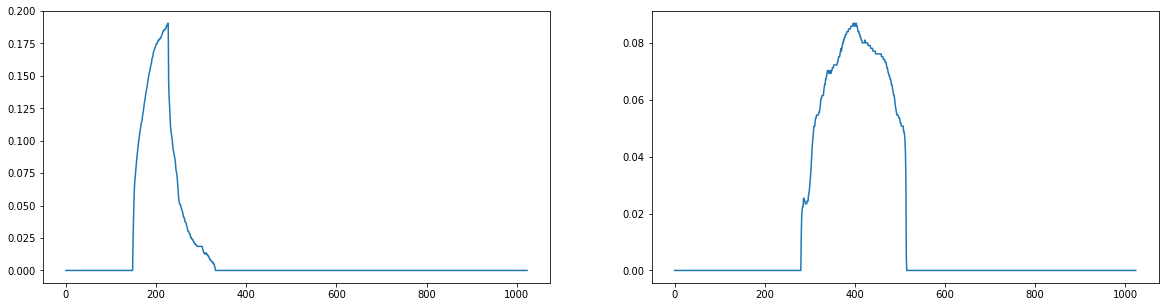

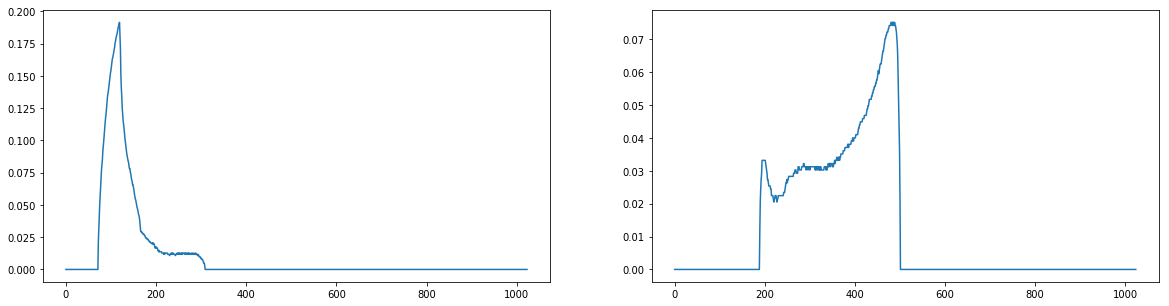

In [54]:
i = 0
for _, (img, mask) in enumerate(iter_dataset()):
    if i > 5:
        break
    y_dim = mask.sum(axis=0) / (1024)
    x_dim = mask.sum(axis=1) / (1024)
    if x_dim.sum() == 0:
        continue
#     y_dim = np.histogram(y_dim, bins=100)[0][1:]
#     x_dim = np.histogram(x_dim, bins=100)[0][1:]
    i += 1
    plt.figure(figsize=(20, 5))
    plt.subplot(121)
    plt.plot(x_dim)
    plt.subplot(122)
    plt.plot(y_dim), plt.show()